In [1]:
import pandas as pd
import numpy as np

import requests

import os
import time
from datetime import datetime
import sys
import yaml
import gc


from data_loader import *
from utils import *
from nn import *
from models import *
from llm import *
from llm_hf import *
import folder_manager

import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#1e1e1e',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.grid': True,
    'grid.color': 'gray'
})

pd.set_option("display.max_column",None)
print(os.getcwd())


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

pd.options.display.max_rows = 100


def auto_reload():
    %load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app


In [2]:
with open("config.yaml",'r') as f:
    config = yaml.safe_load(f)

home_dir = config['HOME_DIRECTORY']
home_dir

'/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG'

In [3]:
create_submodel("llm_new")

# API Football:
https://www.api-football.com

![PYTHON LOGO](https://www.api-football.com/public/img/news/archi-beta.jpg)

In [4]:
leagues_dat = get_leagues(home_dir +"/data/Leagues/leagues.parquet")
leagues_dat[['league_id','league_name','country_name']]

,league_id,league_name,country_name
0,4,Euro Championship,World
1,21,Confederations Cup,World
2,61,Ligue 1,France
3,144,Jupiler Pro League,Belgium
4,71,Serie A,Brazil
...,...,...,...
1128,1131,Super Cup,Mongolia
1129,1132,AFC Challenge League,World
1130,1133,Goiano - 3,Brazil
1131,1001,CONCACAF Women U20,World


# Leagues subset:

In [5]:
# Configs
major_leagues = ["Premier League","La Liga","Serie A","Bundesliga","Eredivisie","Ligue 1"]
major_countries = ["England","Spain","Italy","Germany","Netherlands","France","Brazil"]
teams = ["Liverpool","Wolves"] # teams to pull players data of
seasons = [2022,2021,2023,2024] # seasons to pull players and teams stats of



leagues_subset = leagues_dat[leagues_dat.league_name.isin(major_leagues) & leagues_dat.country_name.isin(major_countries)] # league ID to pull from, current values: {39:premier league}, Add to dictionary as needed

In [6]:
leagues_subset

,seasons,league_id,league_name,league_type,league_logo,country_name,country_code,country_flag
2,"[{'coverage': {'fixtures': {'events': True, 'l...",61,Ligue 1,League,https://media.api-sports.io/football/leagues/6...,France,FR,https://media.api-sports.io/flags/fr.svg
4,"[{'coverage': {'fixtures': {'events': True, 'l...",71,Serie A,League,https://media.api-sports.io/football/leagues/7...,Brazil,BR,https://media.api-sports.io/flags/br.svg
5,"[{'coverage': {'fixtures': {'events': True, 'l...",39,Premier League,League,https://media.api-sports.io/football/leagues/3...,England,GB,https://media.api-sports.io/flags/gb.svg
6,"[{'coverage': {'fixtures': {'events': True, 'l...",78,Bundesliga,League,https://media.api-sports.io/football/leagues/7...,Germany,DE,https://media.api-sports.io/flags/de.svg
7,"[{'coverage': {'fixtures': {'events': True, 'l...",135,Serie A,League,https://media.api-sports.io/football/leagues/1...,Italy,IT,https://media.api-sports.io/flags/it.svg
8,"[{'coverage': {'fixtures': {'events': True, 'l...",88,Eredivisie,League,https://media.api-sports.io/football/leagues/8...,Netherlands,NL,https://media.api-sports.io/flags/nl.svg
10,"[{'coverage': {'fixtures': {'events': True, 'l...",140,La Liga,League,https://media.api-sports.io/football/leagues/1...,Spain,ES,https://media.api-sports.io/flags/es.svg


# Read All fixtures data

In [7]:
teams_dat = pd.read_parquet(home_dir + "/data/Teams/team_league.parquet")

In [8]:
fixtures_dir = home_dir + "/data/Fixtures"

complete_data = pd.DataFrame()
for file in os.listdir(fixtures_dir):
    dat = pd.read_parquet(os.path.join(fixtures_dir,file))
    complete_data = pd.concat([complete_data,dat],axis = 0)

complete_data = complete_data.reset_index()
complete_data.drop(columns = ['index'],inplace=True)

/var/folders/jk/_1sg9wrn0fs6cvslnt6wrqqm0000gp/T/ipykernel_32068/1208416677.py:6: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/var/folders/jk/_1sg9wrn0fs6cvslnt6wrqqm0000gp/T/ipykernel_32068/1208416677.py:6: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/var/folders/jk/_1sg9wrn0fs6cvslnt6wrqqm0000gp/T/ipykernel_32068/1208416677.py:6: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-

In [10]:
complete_data.columns

Index(['player_id', 'player_name', 'offsides', 'games_minutes', 'games_number',
       'games_position', 'games_rating', 'games_captain', 'games_substitute',
       'shots_total', 'shots_on', 'goals_total', 'goals_conceded',
       'goals_assists', 'goals_saves', 'passes_total', 'passes_key',
       'passes_accuracy', 'tackles_total', 'tackles_blocks',
       'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
       'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_commited', 'penalty_scored', 'penalty_missed', 'penalty_saved',
       'fixture_id', 'team_goals_scored', 'team_non_penalty_goals_scored',
       'team_goals_scored_half', 'team_goals_conceded',
       'team_non_penalty_goals_conceded', 'team_goals_conceded_half',
       'opponent', 'fixture_date', 'team_winner', 'team', 'outcome',
       'dribble_success_rate', 'target_shot_conversion_perc', 'duels_won_perc',
     

In [ ]:
# Data checks
complete_data['passes_accuracy'] = complete_data['passes_accuracy'].astype("float64")
complete_data.rename(columns= {'passes_accuracy':'passes_accurate'},inplace =True)
complete_data['fixture_date'] = pd.to_datetime(complete_data.fixture_date)
complete_data['fixture_date_dt'] = complete_data['fixture_date'].dt.date
complete_data = create_datetime_columns(complete_data,'fixture_date')
complete_data['games_rating'] = pd.to_numeric(complete_data['games_rating'])

# Gemini Create season column here:


# Targets
complete_data['outcome_num'] = pd.Categorical(complete_data.outcome).codes

complete_data['win'] = np.where(complete_data.outcome.str.lower() == 'win', 1,0)

# Joins:
complete_data = complete_data.merge(teams_dat.drop_duplicates(),how = 'left', left_on= 'team',right_on = 'team_name').drop(columns = ['team_name'])


/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:48: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:52: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [12]:
complete_data.head()

,player_id,player_name,offsides,games_minutes,games_number,games_position,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,fixture_id,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,opponent,fixture_date,team_winner,team,outcome,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,fixture_date_dt,year_e,month_e,month_name_e,day_of_week_e,day_of_week_name_e,week_e,outcome_num,win,league
0,963,Lukáš Hrádecký,NaN,90.0,1,G,8.9,True,False,NaN,NaN,NaN,0,NaN,6.0,39.0,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,1.0,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,NaN,74.358974,2021-08-21,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1,78
1,152654,Jeremie Frimpong,NaN,90.0,30,D,7.0,False,False,NaN,NaN,NaN,0,NaN,NaN,32.0,1.0,27.0,2.0,NaN,NaN,10.0,5.0,2.0,1.0,1.0,2.0,1.0,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,50.0,NaN,50.000000,84.375000,2021-08-21,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1,78
2,48119,Odilon Kossounou,NaN,90.0,6,D,7.6,False,False,NaN,NaN,NaN,0,NaN,NaN,57.0,1.0,46.0,2.0,1.0,2.0,6.0,5.0,NaN,NaN,1.0,1.0,NaN,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,83.333333,80.701754,2021-08-21,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1,78
3,972,Jonathan Tah,NaN,90.0,4,D,7.2,False,False,NaN,NaN,NaN,0,1.0,NaN,54.0,1.0,51.0,2.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,2.0,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,60.000000,94.444444,2021-08-21,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1,78
4,530,Mitchel Bakker,NaN,90.0,5,D,8.2,False,False,1.0,1.0,1.0,0,1.0,NaN,46.0,1.0,40.0,1.0,NaN,1.0,10.0,6.0,4.0,3.0,NaN,2.0,2.0,1,0,NaN,1.0,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,75.0,100.0,60.000000,86.956522,2021-08-21,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1,78


In [13]:
complete_data.shape

(483394, 61)

In [14]:
# This is the dictionary that contains all information about the features    
dat_dict = find_data_types(complete_data,config['OUTCOME_COLS'] + ['outcome_num','outcome'])
dat_dict = pd.DataFrame(list(dat_dict.items()),columns =['feature','type'])

# differentiate modeling features
non_modeling_features = config['FIXTURE_COLS'] + config['OUTCOME_COLS'] + config['MISC_COLS'] + ['outcome_num','league','win','fixture_date','fixture_date_dt','major_position']
dat_dict['modeling_feature'] = np.where(dat_dict['feature'].isin(non_modeling_features),0,1)
dat_dict['encoded'] = 0

print(dat_dict['type'].value_counts())
dat_dict.reset_index(drop= True)

## Encode Features
dat_dict = create_data_index(complete_data,dat_dict,'target',folder_manager.encoding_path)
dat_dict[dat_dict.modeling_feature ==1]

type
numeric        40
target         10
categorical     6
datetime        3
other           2
Name: count, dtype: int64


,feature,type,modeling_feature,encoded
2,offsides,numeric,1,0
9,shots_total,numeric,1,0
10,shots_on,numeric,1,0
11,goals_total,numeric,1,0
12,goals_conceded,numeric,1,0
13,goals_assists,numeric,1,0
14,goals_saves,numeric,1,0
15,passes_total,numeric,1,0
16,passes_key,numeric,1,0
17,passes_accurate,numeric,1,0


/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_2814/3315404064.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


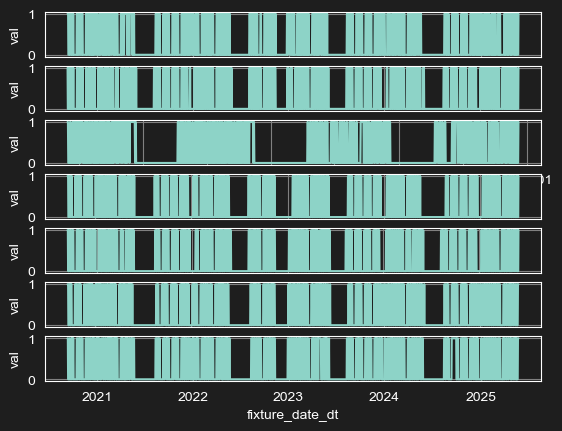

In [20]:
season_dt = complete_data.groupby(['league','fixture_date_dt'],as_index = False).agg(val = ('fixture_date_dt','nunique'))

season_dt = (
    season_dt.groupby("league", group_keys=False)
      .apply(lambda g: (
          g.set_index("fixture_date_dt")
           .asfreq("D")
           .fillna({"val": 0, "league": g.name})
      ))
      .reset_index()
)

fig, axes = plt.subplots(season_dt['league'].nunique(),1)

for ix,league in enumerate(season_dt['league'].unique()):
    sns.lineplot(season_dt[season_dt.league == league], x = "fixture_date_dt",y = "val",ax= axes[ix])


In [ ]:
# primary position map:
player_position = complete_data.groupby(["player_id","games_position"],as_index = False).agg(games_played = ("player_id","size"))
player_position['multiple_records'] = player_position.groupby('player_id')['games_played'].transform("cumsum")
player_position['multiple_records'] = player_position.groupby('player_id')['multiple_records'].transform("max")
player_position['major_position'] = np.where(player_position.games_played/player_position.multiple_records >= .5, player_position.games_position,None)
player_position_map = player_position[['player_id','major_position']].dropna().drop_duplicates()
player_position_map

# Join back to complete_data

complete_data = pd.merge(complete_data,player_position_map,on = 'player_id',how = 'left')

In [ ]:
# Run Player Comparison from LLm 
#player_compare  = compare_players_from_llm(complete_data,["Giovanni Leoni","Ibrahima Konaté"],years = [2025],normalize=True)

In [ ]:
fixture_dat = calculate_fixture_stats(complete_data)

In [ ]:
fixture_dat.head()

In [ ]:
# team classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from category_encoders import OrdinalEncoder
team_class_dat = fixture_dat[['fixture_id','team','opponent','year_e','win']].drop_duplicates()
oe = OrdinalEncoder()
team_class_dat['team_encoded'] = oe.fit_transform(team_class_dat['team'])
team_class_dat['opponent_encoded'] = oe.transform(team_class_dat.drop(columns = 'team').rename(columns={"opponent":'team'})['team']).astype("int")
team_class_dat.head()
team_class_dat['team_cluster'] = 0

for year in team_class_dat.year_e.dropna().unique():
    if year != np.nan:
        print(f"for year {year}")
        dtc = DecisionTreeClassifier(max_depth=4)
        model = dtc.fit(team_class_dat[team_class_dat.year_e == year][['team_encoded','opponent_encoded']],team_class_dat[team_class_dat.year_e == year]['win'].values)
        y_pred = model.predict(team_class_dat[team_class_dat.year_e == year][['team_encoded','opponent_encoded']])
        team_class_dat.loc[team_class_dat['year_e'] == year,'team_cluster'] = model.predict_proba(team_class_dat[team_class_dat.year_e == year][['team_encoded','opponent_encoded']]).max(axis = 1)

team_cluster_map = team_class_dat[['year_e','team','team_cluster']].drop_duplicates().reset_index(drop= True)
team_class_dat = team_class_dat.merge(team_cluster_map,on = ['year_e','team'],how = 'left').rename(columns = {'team_cluster_y':'opponent_cluster',
                                                                                                              'team_cluster_x':'team_cluster'})
team_class_dat['year_e'] = team_class_dat['year_e'].astype('Int64')
oe_cluster = OrdinalEncoder()
team_class_dat['opponent_cluster_encoded'] = oe_cluster.fit_transform(team_class_dat['opponent_cluster'].astype("str"))

# Bayesian Team Ability Estimation

 - team_ability: alpha ~ Normal(mu,sig^2)
 - opposition_difficulty: beta ~ Normal(mu,sig^2)

 - P(w) ~ binomial(N,alpha - beta)

In [ ]:
team_class_dat.head()

In [ ]:
# Data for Binomial Model

team_class_dat_binom = team_class_dat.groupby(['year_e','team','team_encoded','opponent_cluster_encoded'],as_index = False).agg(wins = ('win','sum'), total_games = ('win','size'))
team_class_dat_binom.head()

In [ ]:
team_idx = team_class_dat_binom['team_encoded']
cluster_idx = team_class_dat_binom['opponent_cluster_encoded']
year_idx = team_class_dat_binom['year_e']
coords = {"teams":team_class_dat_binom['team'].unique(),
          "year":team_class_dat_binom['year_e'].unique(),
          "cluster": team_class_dat_binom['opponent_cluster_encoded'].unique()
          }

teams_unique = np.sort(np.unique(team_idx))
team_map = {t:i for i,t in enumerate(teams_unique)}
team_idx_zero = np.array([team_map[t] for t in team_idx])

# Clusters
clusters_unique = np.sort(np.unique(cluster_idx))
cluster_map = {c:i for i,c in enumerate(clusters_unique)}
cluster_idx_zero = np.array([cluster_map[c] for c in cluster_idx])

# Years
years_unique = np.sort(np.unique(year_idx))
year_map = {y:i for i,y in enumerate(years_unique)}
year_idx_zero = np.array([year_map[y] for y in year_idx])

with pm.Model(coords=coords) as model:

    mu_team = pm.Normal("mu_team",0,1)
    sigma_team = pm.HalfNormal('sigma_team',2)

    mu_opponent = pm.Normal("mu_opponent",0,1)
    sigma_opponent = pm.HalfNormal('sigma_opponent',3)

    theta_team_raw = pm.Normal("theta_team_year",0,1,dims= ('teams','year'))
    #theta_team = pm.Deterministic("theta_team",mu_team + theta_team_raw * sigma_team,dims = ('teams','year'))
    theta_team = mu_team + theta_team_raw * sigma_team
    theta = pm.Deterministic('theta', theta_team - theta_team.mean(axis = 0,keepdims = True),dims = ('teams','year'))

    beta_opponent_raw = pm.Normal("beta_opponent_year",0,1,dims= ('cluster','year'))
    #beta_opponent = pm.Deterministic("beta_opponent",mu_opponent + beta_opponent_raw * sigma_opponent,dims = ('cluster','year'))
    beta_opponent = mu_opponent + beta_opponent_raw * sigma_opponent
    beta = pm.Deterministic('beta', beta_opponent - beta_opponent.mean(axis = 0,keepdims = True),dims = ('cluster','year'))

    logit = theta[team_idx_zero,year_idx_zero] - beta[cluster_idx_zero,year_idx_zero]
    p = pm.Deterministic('p',pm.math.sigmoid(logit))
    n = team_class_dat_binom.total_games.values
    outcome = pm.Binomial("outcome", n = n,p = p, observed = team_class_dat_binom.wins.values)

    trace = pm.sample()

   


In [ ]:
pm.summary(trace)

In [ ]:
[val for val in pm.summary(trace).index if 'Liverpool' in val]

In [ ]:
liverpool_post = trace.posterior['theta'].sel(teams = "Liverpool")
liverpool_post.coords
#mancity_post = trace.posterior['theta_alpha'].sel(teams = "Manchester City")

In [ ]:
az.summary(trace).loc["theta_team[Liverpool, 2024]"]

In [ ]:
liverpool_post.coords

In [ ]:
fig, axes = plt.subplots(4,1,figsize = (12,8))
sns.kdeplot(liverpool_post[3],ax= axes[3])
sns.kdeplot(liverpool_post[2],ax= axes[2])
sns.kdeplot(liverpool_post[1],ax= axes[1])
sns.kdeplot(liverpool_post[0],ax= axes[0])

In [ ]:
year_map

In [ ]:
team_class_dat[team_class_dat.team == 'Liverpool']

In [ ]:
team_class_dat['team_cluster'] = team_class_dat['team_cluster'].round(5)

In [ ]:
liverpool_25_cluster = team_class_dat[(team_class_dat.year_e == 2025) & (team_class_dat.team == "Real Madrid")]['team_cluster'].values[0]
liverpool_25_cluster

In [ ]:
team_class_dat[(team_class_dat.team_cluster.round(5) == liverpool_25_cluster) & (team_class_dat.year_e == 2025)]['team'].value_counts()

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=['team','opponent'], class_names=['Lose','Win'], filled=True)
plt.show()

In [ ]:
model.decision_path(team_class_dat[team_class_dat.year_e == year][['team']])

In [ ]:
pd.Series(y_pred_proba.max(axis=1)).value_counts()

In [ ]:
filter = 'games_position.isin(["M","D"]) '
target = 'team_goals_scored'

col_subset = [['win','games_rating','shots_total','shots_on','goals_total','goals_saves','duels_won']]

cor_dat = fixture_dat.query(filter).corr(numeric_only=True)[[target]]
cor_dat.drop(target,inplace = True)

sorted_cols = cor_dat.sort_values(target,ascending = False).index.to_list()

fig, ax = plt.subplots(1,1,figsize = (15,10))
sns.heatmap(cor_dat.loc[sorted_cols],cmap = 'coolwarm',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation =75)
fig.show()

In [ ]:
find_player(complete_data,player_name="Leoni")

In [ ]:
all_defenders_2025 = complete_data[(complete_data.major_position == 'D') & (complete_data.year_e == 2025)]['player_name'].unique()
all_defenders_2025

In [ ]:
defenders_compare = compare_players(complete_data,all_defenders_2025,years = [2025],transpose = False)

In [ ]:
per_90_cols = [col for col in defenders_compare.columns if "per_90" in col]
attack_per_90_cols  = ['total_shots_per_90','shots_on_target_per_90','goals_scored_per_90','assists_per_90',
                       'fouls_drawn_per_90','attempted_dribbles_per_90','successful_dribbles_per_90',
                       'dribble_success_rate_per_90','duels_contested_per_90','duels_won_per_90','duels_won_percentage_per_90']
defense_per_90_cols = ['yellow_cards_per_90','red_cards_per_90','fouls_drawn_per_90','fouls_committed_per_90',
                       'dribbled_past_per_90', 'total_tackles_per_90','blocks_per_90','interceptions_per_90', 
                       'duels_contested_per_90','duels_won_per_90','duels_won_percentage_per_90','penalties_committed_per_90']
pass_per_90_cols = [ 'total_passes_per_90','key_passes_per_90', 'average_passes_accurate_per_90','average_pass_accuracy_per_90']

In [ ]:
defenders_compare.head()

In [ ]:
# Calculate Clusters:
filter = 'total_minutes_played  > 1000'
defense_cluster = 'defense_cluster'
pass_cluster = 'pass_cluster'
defenders_compare_w_cluster = fit_kmeans(defenders_compare.query(filter),defense_per_90_cols,None,cluster_name)
defenders_compare_w_cluster = fit_kmeans(defenders_compare_w_cluster.query(filter),pass_per_90_cols,None,pass_cluster)

In [ ]:
find_player(complete_data,player_name="Virgil van")

In [ ]:
defenders_compare_w_cluster[defenders_compare_w_cluster.player_name.str.contains("William Saliba")]

In [ ]:
defense_cluster

In [ ]:
clusters = defenders_compare_w_cluster[defenders_compare_w_cluster.player_name.str.contains('William Saliba')][[defense_cluster,pass_cluster]].values
clusters
#defenders_compare_w_cluster[defenders_compare_w_cluster[cluster_name].isin(defenders_compare_w_cluster[condition][cluster_name])].sort_values("average_rating",ascending = False)

In [ ]:
folder_manager.llm_code_path

In [ ]:
question = "How are you doing?"
question_no_spec = re.sub(r"[?.,;:]","",question)
split_words = [word for word in question_no_spec.split(" ")]
split_words

In [ ]:
complete_data.columns

In [ ]:
defenders_compare_w_cluster[(defenders_compare_w_cluster.player_name.isin(["Mike Eerdhuijzen","Giovanni Leoni","Nikola Milenković","Marc Guéhi","Ladislav Krejčí"]))][['player_name'] + [col for col in defenders_compare.columns if "per_90" in col]].T

In [ ]:
schema = {
        "columns": list(complete_data.columns),
        "nrows": [complete_data.shape[0]],
        "dtypes": {col : str(complete_data[col].dtype) for col in complete_data.columns}
    }


In [ ]:
complete_data.columns

In [ ]:
plot_from_llm(complete_data[complete_data.player_name == 'Olivier Boscagli'],"Plot Average games_rating with error cloud by month_e faceted by team")

In [ ]:
plot_continuous_trend(complete_data[complete_data.player_name == 'Emmanuel Agbadou'],"month_e","games_rating")

In [ ]:
filter_query = 'major_position.isin(["M"])'


# Stat to look at:
stat = 'target_shot_conversion_perc'
agg_fun = "mean"
rank_cutoff = 20

# configs 
min_appearance = 40

dribble_dat_g = complete_data.query(filter_query).reset_index().fillna(0).groupby("player_name").agg(n_apps = ("player_name","size"),stat = (stat,agg_fun)).reset_index()
dribble_dat_g = dribble_dat_g[dribble_dat_g.n_apps >= min_appearance]
dribble_dat_g['rank'] = dribble_dat_g["stat"].fillna(0).rank(ascending= False,method = 'dense')
dribble_dat_g.sort_values("rank",inplace = True)

fig, ax = plt.subplots(figsize=(13, 8))

# Plot correctly, no comma here
sns.boxplot(
    data=complete_data.query(filter_query)[complete_data.query(filter_query).player_name.isin(dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'])],
    x="player_name",
    y=stat,
    order=dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'],
    ax=ax,
    
)

# Now this works correctly on `ax`
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(f"Stat: {stat}")
plt.tight_layout()
plt.show()


In [ ]:
fig = plt.subplots(nrows=1, ncols = 1, figsize = (20,10))
fig = sns.heatmap(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']].corr(),cmap = 'coolwarm')
fig.set_xticklabels(fig.get_xticklabels(),rotation = 60)

In [ ]:
sns.pairplot(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']])

In [ ]:
complete_data.columns

In [ ]:
config['PASSING_COLS'] + config['DEFENSE_COLS']

In [ ]:
# trial multiclass model:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete_data.query(filter_query)[list(set(config['PASSING_COLS'] + config['DEFENSE_COLS'] ))],
                                                    complete_data.query(filter_query)['win'],
                                                    stratify=complete_data.query(filter_query)['win'],
                                                    random_state=33)


In [ ]:
create_submodel("catboost")

In [ ]:
output_path

In [ ]:
model = run_model_with_fs_tune(X_train, X_test, y_train, y_test,dat_dict,'catboost',output_path=folder_manager.output_path)

In [ ]:
dat = NNDataFromPd(X_train.fillna(0), y_train.outcome_num, dat_dict)
train_loader = DataLoader(dat, batch_size = 128,shuffle= True)

In [ ]:
train_loader.dataset.X_numeric_tensor.shape

In [ ]:
# model params
n_features = X_train.shape[1]
n_classes = y_train.iloc[:,0].nunique()
model = MultiClassModel(n_features,n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
epochs = 500

for epoch in range(epochs):
    
    epoch_loss = 0

    for X_numeric_batch, X_categoric_batch, y_batch in train_loader:
        
        pred = model.forward(X_numeric_batch)
        
        loss = criterion(pred,y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

In [ ]:
model.eval()

In [ ]:
X_test['passes_accuracy'] = X_test['passes_accuracy'].astype("float64")

In [ ]:
# test sets

test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

In [ ]:
model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_class = torch.argmax(output, dim = 1)

In [ ]:
# Logistic Model:
X_train, X_test, y_train, y_test = train_test_split(complete_data[complete_data.games_position == 'F'][list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['win']].drop(columns = 'win'),
                                                    complete_data[complete_data.games_position == 'F']['win'],
                                                    stratify=complete_data['win'],
                                                    random_state=33)

In [ ]:
train_dat = NNDataFromPd(X_train,y_train,dat_dict)
train_loader = DataLoader(train_dat,batch_size= 128,shuffle = True)

In [ ]:
n_features = X_train.shape[1]
model = LogisticNNModelComplex(n_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.005)

In [ ]:
epochs = 500
for epoch in range(epochs):
    epoch_loss = 0
    
    for X_numeric, X_categoric, y in train_loader:

        pred = model(X_numeric)

        loss = criterion(pred,y.unsqueeze(1))

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch},  Loss: {loss}")


In [ ]:
pred_proba.squeeze(1)

In [ ]:
from validations import *


test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_proba = torch.softmax(output,dim =1)
        pred_class = torch.argmax(output, dim = 1)


discrete_evaluations(y_test,pred_class,pred_proba.squeeze(1),classification_type="Binary",model_path= folder_manager.output_path)

In [ ]:
test_fixtures = get_team_fixtures("Liverpool",2)

In [ ]:
test_fixtures

In [ ]:
player_stat_url = "https://v3.football.api-sports.io/fixtures/players?fixture={}".format(1035045)
fixture_dat = requests.get(player_stat_url,headers=headers_api_sport)

In [ ]:
pd.json_normalize(pd.json_normalize(fixture_dat.json()['response']))['players'][0]

In [ ]:
fixture_dat_expanded = pd.concat([pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])[['player.id','player.name']],pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])['statistics']).rename(columns = {0:"player_stats"})['player_stats'])],axis = 1)

In [ ]:
fixtures_stat = complete_data.groupby(['fixture_id','team'],as_index=False).agg(n_opponent = ('opponent','count'),total_passes = ('passes_total','sum')).sort_values('fixture_id',ascending= False)

In [ ]:
fixtures_stat

In [ ]:
complete_data[complete_data.fixture_id == 1376437][['team','opponent']]

In [ ]:
teams_dat[teams_dat.team_name.str.contains("Tels")]

In [ ]:
angers = pd.read_parquet(home_dir + "/data/Fixtures/angers_2024.parquet")

In [ ]:
angers['fixture_date'] = pd.to_datetime(angers['fixture_date'])

In [ ]:
angers['fixture_date']